In [1]:
import os
from pathlib import Path
import numpy as np
import cv2
%pylab inline

import lib.orientation as orient
from lib.camera import img_from_device, denormalize, view_frame_from_device_frame

Populating the interactive namespace from numpy and matplotlib


In [2]:
from utils.paths import get_local_path

## Using the comma library to display the driven path 

In [3]:
example_segment = Path("/media/watouser/Seagate_Backup/datasets/comma2k19/Chunk_3/99c94dc769b5d96e|2018-05-05--11-09-01/12")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Driven path projected onto first image')

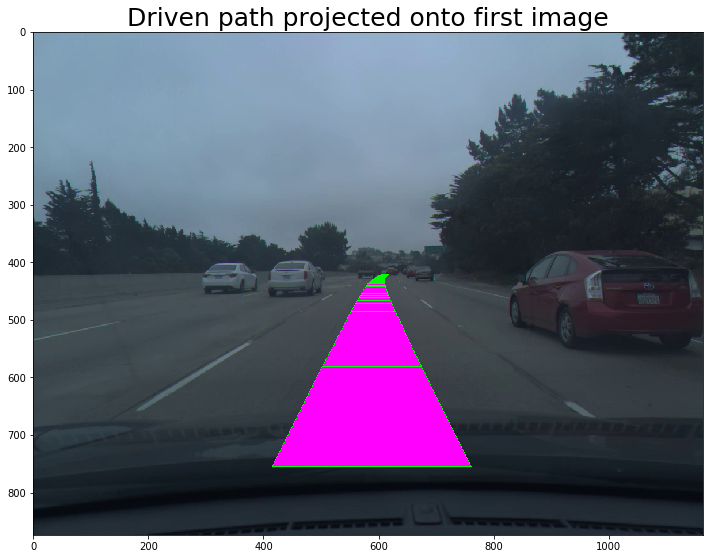

In [44]:
# We can project the path driven onto the first image
frame_times = np.load(example_segment / 'global_pose/frame_times')
frame_positions = np.load(example_segment / 'global_pose/frame_positions')
frame_orientations = np.load(example_segment / 'global_pose/frame_orientations')

# first we convert the frame_positions to the frame
# defined by the pose of the first frame
ecef_from_local = orient.rot_from_quat(frame_orientations[0])
local_from_ecef = ecef_from_local.T
frame_positions_local = np.einsum('ij,kj->ki', local_from_ecef, frame_positions - frame_positions[0])

def draw_path(device_path, img, width=0.5, height=1, fill_color=(128,0,255), line_color=(0,255,0)):
    device_path_l = device_path + np.array([0, 0, height])                                                                    
    device_path_r = device_path + np.array([0, 0, height])                                                                    
    device_path_l[:,1] -= width                                                                                               
    device_path_r[:,1] += width

    img_points_norm_l = img_from_device(device_path_l)
    img_points_norm_r = img_from_device(device_path_r)
    img_pts_l = denormalize(img_points_norm_l)
    img_pts_r = denormalize(img_points_norm_r)

    # filter out things rejected along the way
    valid = np.logical_and(np.isfinite(img_pts_l).all(axis=1), np.isfinite(img_pts_r).all(axis=1))
    img_pts_l = img_pts_l[valid].astype(int)
    img_pts_r = img_pts_r[valid].astype(int)

    for i in range(1, len(img_pts_l)):
        u1,v1,u2,v2 = np.append(img_pts_l[i-1], img_pts_r[i-1])
        u3,v3,u4,v4 = np.append(img_pts_l[i], img_pts_r[i])
        pts = np.array([[u1,v1],[u2,v2],[u4,v4],[u3,v3]], np.int32).reshape((-1,1,2))
        cv2.fillPoly(img,[pts],fill_color)
        cv2.polylines(img,[pts],True,line_color)

img = imread(str(example_segment / 'preview.png'))
draw_path(frame_positions_local[1:61], img) # show next 3 seconds (60 frames)
figsize(12,12);
imshow(img)
title('Driven path projected onto first image', fontsize=25)

In [45]:
frame_positions_local[1:61] # (n, 3) where cols are x,y,z
# These are the coordinates of the path in 3D space relative to the reference frame
# x is the axis along the length of the car
# y is the axis along the width of the car
# z is the axis along the height of the car

array([[ 1.31603485e+00,  8.41989308e-03, -4.06417522e-02],
       [ 2.63265307e+00,  1.79573186e-02, -8.13818546e-02],
       [ 3.94694805e+00,  2.89779373e-02, -1.21938900e-01],
       [ 5.26289086e+00,  4.17516320e-02, -1.62270694e-01],
       [ 6.57753351e+00,  5.58037363e-02, -2.02489661e-01],
       [ 7.89309645e+00,  7.10305902e-02, -2.42974319e-01],
       [ 9.20866394e+00,  8.71150723e-02, -2.83763866e-01],
       [ 1.05246901e+01,  1.03760107e-01, -3.24787259e-01],
       [ 1.18408830e+01,  1.22022175e-01, -3.66510441e-01],
       [ 1.31563772e+01,  1.41245287e-01, -4.09070804e-01],
       [ 1.44723788e+01,  1.61723662e-01, -4.52273221e-01],
       [ 1.57902086e+01,  1.83738687e-01, -4.95651219e-01],
       [ 1.71051426e+01,  2.06693263e-01, -5.38603159e-01],
       [ 1.84208709e+01,  2.30760741e-01, -5.81181977e-01],
       [ 1.97366228e+01,  2.56164414e-01, -6.23714943e-01],
       [ 2.10514693e+01,  2.82345936e-01, -6.66312531e-01],
       [ 2.23671198e+01,  3.09627995e-01

## Finding the fps of the data stream

In [46]:
frame_times.shape

(1200,)

In [47]:
frame_times

array([826.499643, 826.549659, 826.599692, ..., 886.348804, 886.398825,
       886.448799])

In [48]:
frame_len = (frame_times[-1] - frame_times[0])/frame_times.shape[0]
print(frame_len) # Each frame is ~0.05 seconds apart (20 fps)
n = 3
print(n/frame_len) # Number of frames needed for n seconds

0.04995763000000002
60.050887121746946


## Loading in the processed dataset and getting the driven path

In [49]:
dataset_path = Path("/media/watouser/Seagate_Backup/datasets/comma2k19/processed_dataset")

In [59]:
segment_path = dataset_path / '2018-07-20--16-43-04'
for file in segment_path.glob('*'):
    print(file)

/media/watouser/Seagate_Backup/datasets/comma2k19/processed_dataset/2018-07-20--16-43-04/CAN_angles.npy
/media/watouser/Seagate_Backup/datasets/comma2k19/processed_dataset/2018-07-20--16-43-04/CAN_speeds.npy
/media/watouser/Seagate_Backup/datasets/comma2k19/processed_dataset/2018-07-20--16-43-04/frame_orientations.npy
/media/watouser/Seagate_Backup/datasets/comma2k19/processed_dataset/2018-07-20--16-43-04/frame_positions.npy
/media/watouser/Seagate_Backup/datasets/comma2k19/processed_dataset/2018-07-20--16-43-04/frame_times.npy
/media/watouser/Seagate_Backup/datasets/comma2k19/processed_dataset/2018-07-20--16-43-04/frame_velocities.npy
/media/watouser/Seagate_Backup/datasets/comma2k19/processed_dataset/2018-07-20--16-43-04/images


In [60]:
# Load in data for this segment
frame_times = np.load(segment_path / 'frame_times.npy')
steering_angles = np.load(segment_path / 'CAN_angles.npy')
frame_positions = np.load(segment_path / 'frame_positions.npy')
frame_orientations = np.load(segment_path / 'frame_orientations.npy')
frame_velocities = np.load(segment_path / 'frame_velocities.npy')
frame_speed = np.linalg.norm(frame_velocities, axis=1) # predict this during training

In [61]:
def get_local_path(positions, orientations, reference_idx):
    # Define the segment frame positions referenced at a desired frame
    ecef_from_local = orient.rot_from_quat(orientations[reference_idx])
    local_from_ecef = ecef_from_local.T
    positions_local = np.einsum('ij,kj->ki', local_from_ecef, positions - positions[reference_idx])
    return positions_local

Text(0.5, 1.0, 'Frame 4280')

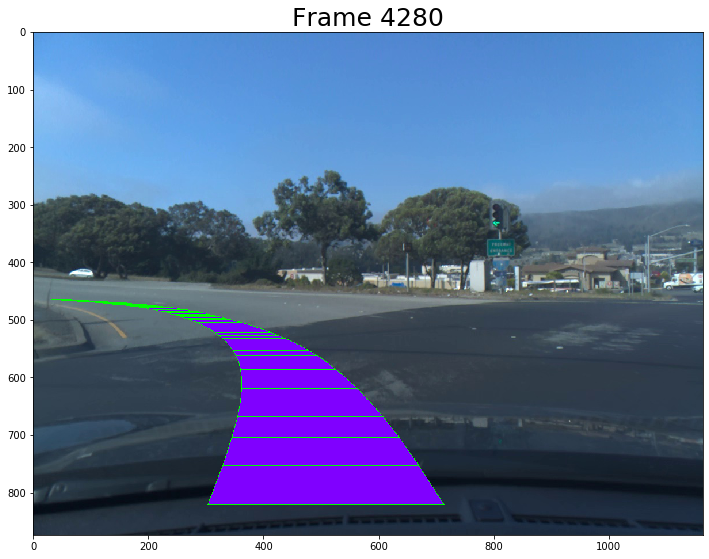

In [62]:
index = 4280
local_path = get_local_path(frame_positions, frame_orientations, index)
img_name = str(index).zfill(6) + '.jpg'
image = imread(str(segment_path / 'images' / img_name))
draw_path(local_path[index:index+60], image) # show 3 seconds
figsize(12,12);
imshow(image)
title(f"Frame {index}", fontsize=25)

In [63]:
local_path[index:index+60]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.33103018e-01, -1.87456461e-02, -1.55951194e-02],
       [ 8.71215180e-01, -4.61664536e-02, -3.07133016e-02],
       [ 1.31408317e+00, -8.13687067e-02, -4.42781848e-02],
       [ 1.76211378e+00, -1.25057976e-01, -5.55632038e-02],
       [ 2.21498528e+00, -1.77758084e-01, -6.44454272e-02],
       [ 2.67281998e+00, -2.40857876e-01, -7.13959222e-02],
       [ 3.13447809e+00, -3.13541503e-01, -7.71620346e-02],
       [ 3.59948721e+00, -3.95872166e-01, -8.24004695e-02],
       [ 4.06638489e+00, -4.89091989e-01, -8.74917942e-02],
       [ 4.53544833e+00, -5.92982160e-01, -9.26349128e-02],
       [ 5.00509349e+00, -7.07120470e-01, -9.76757299e-02],
       [ 5.47521866e+00, -8.32840579e-01, -1.02880952e-01],
       [ 5.94538216e+00, -9.69456263e-01, -1.08413120e-01],
       [ 6.41627999e+00, -1.11744712e+00, -1.13902759e-01],
       [ 6.88765487e+00, -1.27657840e+00, -1.18683133e-01],
       [ 7.36082851e+00, -1.44543300e+00

In [64]:
steering_angles[index:index+60]

array([106.6, 104.6, 103.8, 103.7, 103.1, 103. , 103. , 103.6, 103.9,
       103.9, 103.6, 102.9, 101.8, 100.1,  95.1,  88. ,  80.6,  73.3,
        68.1,  66.5,  66.4,  66.5,  66.5,  66.5,  66.5,  66.5,  66.5,
        66.6,  66.6,  66.5,  66.2,  65.5,  63.2,  60.1,  58.3,  57.9,
        57.9,  57.7,  57.3,  55.7,  51.9,  46.8,  43.1,  41.6,  40.9,
        40. ,  38.4,  34.6,  30.3,  26.3,  23.4,  21.5,  20.3,  19.3,
        18.7,  18.1,  17.4,  16.7,  15.9,  15.3])

In [58]:
frame_velocities[index:index+60]

array([[ 1.2703352 , -0.06413635,  0.90809891],
       [ 1.22404152, -0.07604467,  0.83966651],
       [ 1.16223077, -0.07188167,  0.78950589],
       [ 1.09031307, -0.05116876,  0.75047736],
       [ 1.02586357, -0.02004924,  0.71913353],
       [ 0.95854688,  0.01957262,  0.68507765],
       [ 0.89944127,  0.04662159,  0.65052123],
       [ 0.84175605,  0.05992634,  0.61542689],
       [ 0.79220783,  0.05825894,  0.58046598],
       [ 0.75037062,  0.04226139,  0.54236844],
       [ 0.71431712,  0.02093298,  0.50309653],
       [ 0.67525114,  0.00727056,  0.4665399 ],
       [ 0.63517182,  0.0032828 ,  0.43160608],
       [ 0.5930569 ,  0.00591693,  0.39817387],
       [ 0.55211541,  0.01090971,  0.3700171 ],
       [ 0.51656696,  0.01728944,  0.34752272],
       [ 0.49125745,  0.02227063,  0.3275848 ],
       [ 0.47615981,  0.02305356,  0.31067673],
       [ 0.4737495 ,  0.02052413,  0.30343646],
       [ 0.48297008,  0.01664845,  0.30579384],
       [ 0.50010015,  0.01199676,  0.316